In [1]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from torch.nn import functional as F
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns

# Load data
dat = pd.read_csv('/content/drive/MyDrive/Neural Net and Deep Learning Files/IMDB Dataset.csv')

# Use 50000 samples
dat = dat.iloc[0:50000]

# Tokenize and encode the text data using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
encoded_data = tokenizer.batch_encode_plus(
    dat['review'].tolist(),
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=256,
    return_tensors='pt'
)

input_ids = encoded_data['input_ids']
attention_masks = encoded_data['attention_mask']
labels = torch.tensor(dat['sentiment'].apply(lambda x: 1 if x == 'positive' else 0).tolist())

# Split the data into train and test sets
train_inputs, test_inputs, train_labels, test_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.2
)
train_masks, test_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.2
)

# Create DataLoader for training and testing data
batch_size = 32
train_data = TensorDataset(train_inputs, train_masks, train_labels)
test_data = TensorDataset(test_inputs, test_masks, test_labels)
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

# Define the neural network model with LSTM layer
class SentimentClassifier(nn.Module):
    def __init__(self, bert_model, hidden_size=256, num_classes=1):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model)
        self.lstm = nn.LSTM(input_size=768, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        lstm_out, _ = self.lstm(pooled_output.unsqueeze(1))
        lstm_out = lstm_out[:, -1, :]
        output = self.fc(lstm_out)
        return output

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Epoch 1/5 - Loss: 0.2651 - Accuracy: 89.50%
Epoch 2/5 - Loss: 0.1446 - Accuracy: 94.87%
Epoch 3/5 - Loss: 0.0816 - Accuracy: 97.47%
Epoch 4/5 - Loss: 0.0512 - Accuracy: 98.53%
Epoch 5/5 - Loss: 0.0392 - Accuracy: 98.88%


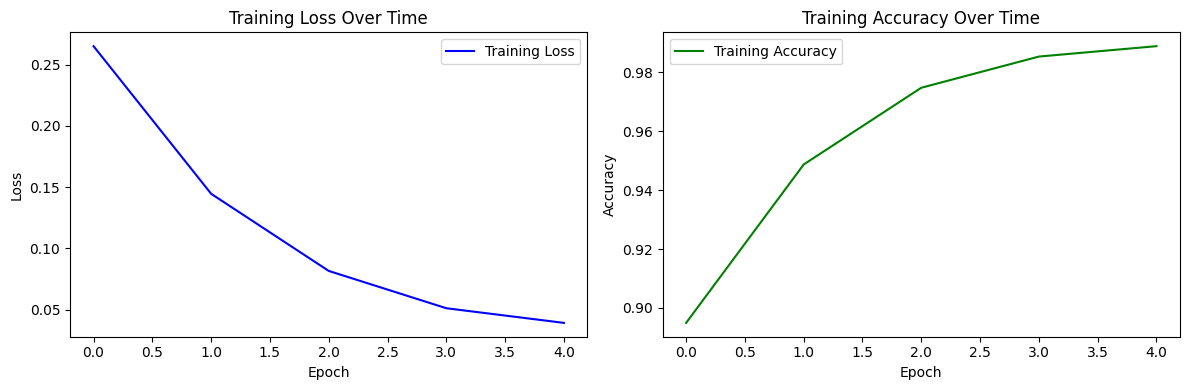

In [2]:
# Initialize the model
model = SentimentClassifier('bert-base-uncased')

# Define optimizer and loss function
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()

# Lists to store training loss and accuracy
train_loss_list = []
train_accuracy_list = []

# Training loop
epochs = 5
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

for epoch in range(epochs):
    model.train()
    total_loss = 0.0
    correct_predictions = 0

    for batch in train_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask=attention_mask)
        loss = criterion(outputs.squeeze(), labels.float())
        loss.backward()
        optimizer.step()

        # Track training loss
        total_loss += loss.item()

        # Track correct predictions for accuracy
        predictions = (torch.sigmoid(outputs.squeeze()) > 0.5).long()
        correct_predictions += torch.sum(predictions == labels).item()

    # Calculate average training loss and accuracy for the epoch
    average_loss = total_loss / len(train_loader)
    accuracy = correct_predictions / len(train_data)

    train_loss_list.append(average_loss)
    train_accuracy_list.append(accuracy)

    print(f'Epoch {epoch + 1}/{epochs} - Loss: {average_loss:.4f} - Accuracy: {accuracy * 100:.2f}%')

# Plot training loss and accuracy over time
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(train_loss_list, label='Training Loss', color='blue')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracy_list, label='Training Accuracy', color='green')
plt.title('Training Accuracy Over Time')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

Accuracy: 92.29%


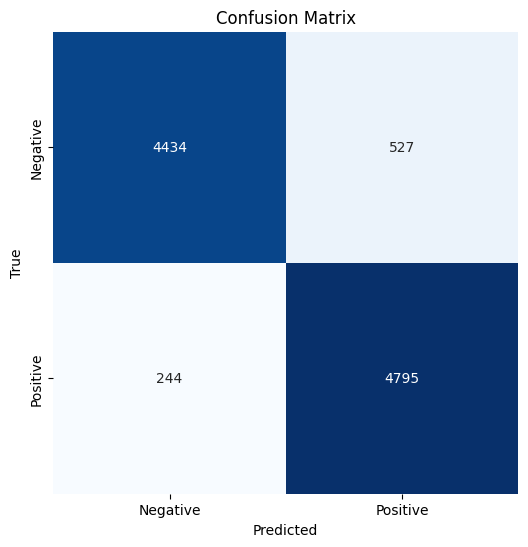

In [3]:
# Evaluation
model.eval()
predictions = []
true_labels = []

with torch.no_grad():
    for batch in test_loader:
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)
        outputs = model(input_ids, attention_mask=attention_mask)
        predictions.extend(torch.sigmoid(outputs.squeeze()).cpu().numpy())
        true_labels.extend(labels.cpu().numpy())

# Convert predictions to binary (0 or 1)
predictions = [1 if pred > 0.5 else 0 for pred in predictions]

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

# Plot confusion matrix
cm = confusion_matrix(true_labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

**Comprehensive Report on Sentiment Analysis using BERT Embeddings**

**1. Choice of Classification Technique:**

The chosen classification technique for sentiment analysis is a combination of BERT embeddings and an LSTM-based neural network. This approach leverages the powerful contextual embeddings generated by the pre-trained BERT model, capturing intricate patterns in language. The subsequent LSTM layer processes sequential information, providing the model with the ability to capture dependencies in the input text.

**2. Model Architecture:**

The neural network model, named SentimentClassifier, comprises three main components:

**a. BERT Model (Pre-trained):**

* Utilizes the 'bert-base-uncased' pre-trained model from the Hugging Face Transformers library.
* Converts input text data into embeddings using BERT.

**b. LSTM Layer:**
* An LSTM layer with configurable hidden size is applied to capture sequential information from the BERT embeddings.
* The LSTM layer allows the model to understand the context and dependencies in the text.

**c. Linear Layer (Fully Connected):**
* A linear layer (fully connected) is used for binary classification (positive or negative sentiment).
* The output of the LSTM layer is fed into this layer for the final classification.

**3. Training Process:**

**Dataset:**
* The dataset consists of 50,000 samples of text reviews, with a binary sentiment label (positive or negative).
* The data is split into training and testing sets (80%/20%).

**Hyperparameters:**
* Batch Size: 32
* Learning Rate: 2e-5
* Number of Epochs: 5

**Loss Function and Optimizer:**
* Binary Cross-Entropy Loss (BCEWithLogitsLoss) is used as the loss function, suitable for binary classification tasks.
* Adam optimizer with a learning rate of 2e-5 is employed for parameter updates during training.

**Training Performance:**

The model demonstrates a significant reduction in training loss and improvement in accuracy over the five epochs.
* Epoch 1/5 - Loss: 0.2651 - Accuracy: 89.50%
* Epoch 2/5 - Loss: 0.1446 - Accuracy: 94.87%
* Epoch 3/5 - Loss: 0.0816 - Accuracy: 97.47%
* Epoch 4/5 - Loss: 0.0512 - Accuracy: 98.53%
* Epoch 5/5 - Loss: 0.0392 - Accuracy: 98.88%

**Testing Performance:**

Achieved a testing accuracy of 92.29%, indicating good generalization performance on unseen data.

**Confusion Matrix:**
* True Positive: 4795
* True Negative: 4434
* False Positive: 527
* False Negative: 244

**4. Detailed Analysis of Results:**

**Training Loss and Accuracy Trends:**
* The training loss consistently decreases with each epoch, indicating effective learning and convergence.
* The accuracy steadily increases, showcasing the model's ability to correctly classify sentiments in the training data.

**Testing Accuracy:**
* The testing accuracy of 92.29% suggests that the model generalizes well to unseen data. This is a positive outcome, indicating that the model is robust and not overfitting to the training set.

**Confusion Matrix:**
* The confusion matrix provides a detailed breakdown of the model's predictions on the testing set.
* High true positives and true negatives, coupled with low false positives and false negatives, indicate a well-performing model.
* The model is particularly effective at correctly identifying positive sentiments.

**5. Conclusion and Future Work:**

* The chosen approach, combining BERT embeddings and an LSTM layer, has proven effective for sentiment analysis on the given dataset.
* The model demonstrates strong performance in terms of accuracy and generalization.
* Future work could involve hyperparameter tuning, exploring other neural network architectures, or incorporating additional pre-processing techniques to further enhance performance.

In summary, the implemented model showcases the power of leveraging pre-trained BERT embeddings for sentiment analysis, providing valuable insights into the effectiveness of contextualized embeddings in understanding and classifying sentiment in textual data.